<center>
    
    Machine Learning
    
    Author: Daniel Coble
</center>

In the last notebook, we wrote out the inference and training of an NN by hand. I think we can all agree that writing all of that out sucks a lot, and that it would be annoying to re-derive the backpropagation equations each time we change the shape of a model. Luckily, just like everything else we've implemented by hand, there's already a package for that. In fact, there are multiple. In this notebook, we'll use `tensorflow` and it's high-level, user-friendly interface `keras` (`pytorch` is another common ML package). Using a package means that we can use bigger data and bigger models. In short, we can start doing stuff that actually looks like machine learning. But the principle is still the same: just like in the last notebook, we have a dataset $\{x_i, y_i\}_{i=1}^N$, and want to develop a function $\phi$ which approximates $\phi(x_i)\approx y_i$. 

This notebook will go through a simple example of training an ML model using `keras`. Along the way, we'll discuss what's going on under-the-hood of the library, and best practices for creating ML models. 

Since this is supposed to be an introduction to machine learning for mechanical engineers, let's return again to the FEA beam that we used before. I've put the code to produce the dataset in fea.py so that we can load it here. `f` is the forcing function applied to the end of the beam, and you may find it interesting to mess around with changing `f`.

Resources:
[keras API](https://www.tensorflow.org/guide/keras)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from fea import fea_beam

'''
forcing at the free end. Note that since 3*pi is irrational and 15 is rational, this forcing function is non-periodic.
'''
f = lambda t: .1*np.sin(3*np.pi/2*t) + .1*np.sin(15*t)

'''
parameters:
f: forcing function (maybe measured in kN)
t: total time (maybe measured in s)
returns:
W: displacement array with shape [timestep, node] (maybe measured in mm)
t: time array (maybe measured in s)
x: node points in the beam (maybe measured in m)
'''
(W, t, x) = fea_beam(f, t=50)

Let's make an animation of the beam vibration.

<IPython.core.display.Javascript object>


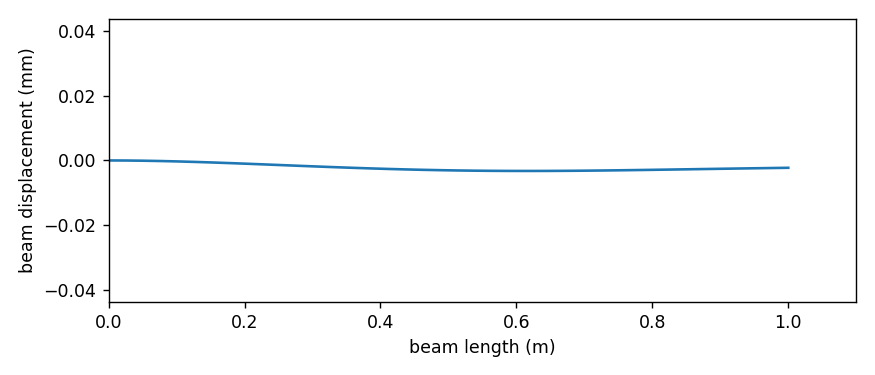

In [2]:
import matplotlib.animation
plt.ioff()
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"

fig, ax = plt.subplots(figsize=(7, 3))
ax.set_xlim((0, 1.1*x[-1]))
max_displacement = np.max(np.abs(W))
ax.set_ylim((-1.1*max_displacement, 1.1*max_displacement))
ax.set_xlabel('beam length (m)')
ax.set_ylabel('beam displacement (mm)')
fig.tight_layout()
l, = ax.plot([],[])

def animate(i):
    l.set_data(x, W[i])

ani1 = matplotlib.animation.FuncAnimation(fig, animate, frames=t.size, interval=(1/100)*1000)

Here's the problem we'll act like we're solving. Say that this beam represents an airplane wing and it's of interest to know what the deflection is at the very tip. However, it's impossible to measure deflection at the tip (perhaps we can't install a sensor there). We can put sensors up to half the length of the beam, and we want to use the data from those to guess at the deflection at the tip. In this scenario, imagine that the geometry is more complicated than just a beam, so that it would be impossible or impractical to create a closed-form solution to the problem. Therefore, we're resorting to ML to solve the problem.

In [3]:
from sklearn import model_selection

# for X data, use five node points from the first half of the beam
X = W[:,3:20:4]
x_node_points = x[3:20:4]
# for y data, use the end node point
y = W[:,-1].reshape(-1, 1)

'''
NNs often suffer from a problem known as overfitting. You can think of this as the model learning to match the points in
the training set, but not accurately representing the function which we are trying to approximate at points away
from the training datapoints. To measure for this, it is common to remove a portion of the dataset for 'validation'.
If the model performs as well on the validation dataset as the training dataset, then it is fitting to the pattern of the
data rather than the points. sklearn.model_selection has a pre-built function which randomly divides a dataset into train and
test sets.
'''
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

Train the neural network.

In [4]:
from tensorflow import keras

'''
This is the code do instantiate a model in keras. This model has four layers. The first three each have 32 'units', which is
the output dimension, and uses a sigmoid activation function. The final layer has 1 unit to bring the output dimension to the
desired one prediction point. input_shape=(5,) matches the five sensor points which are used as an input.
'''
model = keras.Sequential([
    keras.layers.Dense(32, input_shape=(5,), activation='sigmoid'),
    keras.layers.Dense(32, activation='sigmoid'),
    keras.layers.Dense(32, activation='sigmoid'),
    keras.layers.Dense(1)
])

'''
In the last notebook, we pure gradient descent in the sense that we found the direction of quickest descent, and moved in that
way. Actually, we don't always want to do that, and people have come up with all sorts of optimizer algorithms which convert
the calculated gradient into a direction to move in the weight space. Given that, it may be more accurate ML as using 
'gradient-informed' rather than 'gradient descent' algorithms. But most people ignore this fact and just call it gradient
descent. The Adam optimizer uses an equation to combine the gradients from the last few steps, and generally works better 
than pure gradient descent.
'''
adam = keras.optimizers.Adam(learning_rate=.005)

'''
model.compile associates our chose optimizer and loss function (mean squared error) with the model. It's also at this step
that the weights/biases are initialized as random matrices/vectors. 
'''
model.compile(optimizer=adam, loss=keras.losses.MeanSquaredError())

'''
Now we train the model. We pass model.fit the training dataset X_train and y_train. The number of epochs is the amount of
passes through the dataset. Batch size is how many samples are taken together when calculating the gradient for one batch.
Weights are updated after each batch. Validation X and y data are also passed and validation loss is calculated at the end
of each epoch. model.fit returns a history which contains the loss and validation loss at each epoch. Just remember that
loss is a bit misleading since the model is changing throughout an epoch.
'''
n_epochs = 50
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=64,
                    validation_data=(X_test, y_test)
)
'''
After training the model, we want to analyze the results. model.predict runs a prediction for each sample in X. Here we
predict the entire dataset, and then separately predict just from the valiation set.
'''
y_pred = model.predict(X)
y_test_pred = model.predict(X_test)

Epoch 1/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 1.1429e-04
Epoch 2/50
250/250 [==============================] - 0s 1ms/step - loss: 1.1003e-04 - val_loss: 1.1289e-04
Epoch 3/50
250/250 [==============================] - 0s 1ms/step - loss: 1.0864e-04 - val_loss: 1.1237e-04
Epoch 4/50
250/250 [==============================] - 0s 1ms/step - loss: 1.0384e-04 - val_loss: 1.0958e-04
Epoch 5/50
250/250 [==============================] - 0s 1ms/step - loss: 1.0202e-04 - val_loss: 1.0354e-04
Epoch 6/50
250/250 [==============================] - 0s 1ms/step - loss: 9.9090e-05 - val_loss: 1.0152e-04
Epoch 7/50
250/250 [==============================] - 0s 1ms/step - loss: 9.7291e-05 - val_loss: 9.9416e-05
Epoch 8/50
250/250 [==============================] - 0s 1ms/step - loss: 9.5117e-05 - val_loss: 9.1450e-05
Epoch 9/50
250/250 [==============================] - 0s 1ms/step - loss: 9.1002e-05 - val_loss: 9.2483e-05
Epoch 10/50
250/250 [===========

Now let's plot how loss changed with each epoch. This will show us the convergence of training. Based on whether error is still decreasing or not, We can see if we stopped training too early, or let it continue for too long.

<IPython.core.display.Javascript object>


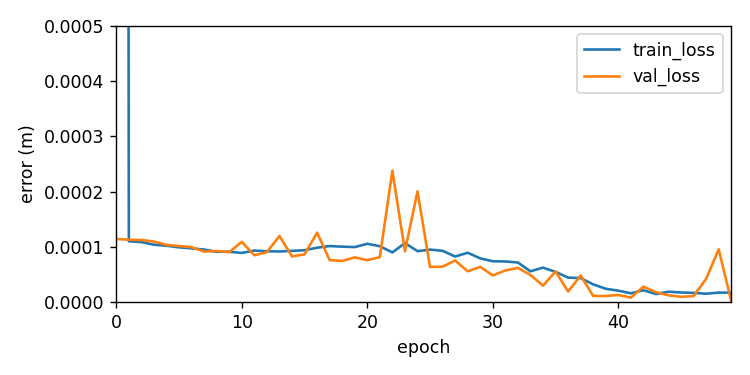

In [5]:
val_loss = history.history['val_loss']
train_loss = history.history['loss']

plt.figure(figsize=(6, 3))
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlim((0, n_epochs-1))
plt.ylim((0, 0.0005))
plt.legend(loc=1)
plt.xlabel('epoch')
plt.ylabel('error (m)')
plt.tight_layout()

Let's recreate the animation from before, but now include our measured sensor points, the true end point, and predicted end point. We can visually see whether the model does a good job.

<IPython.core.display.Javascript object>


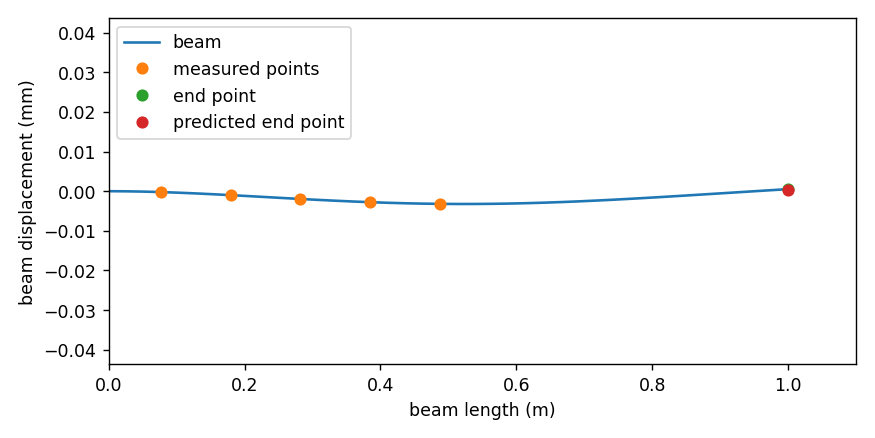

In [6]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(7, 3.5))
ax.set_xlim((0, 1.1*x[-1]))
max_displacement = np.max(np.abs(W))
ax.set_ylim((-1.1*max_displacement, 1.1*max_displacement))
ax.set_xlabel('beam length (m)')
ax.set_ylabel('beam displacement (mm)')
l1, = ax.plot([],[], label='beam')
l2, = ax.plot([],[], marker='o', linewidth=0, label='measured points')
l3, = ax.plot([],[], marker='o', linewidth=0, label='end point')
l4, = ax.plot([],[], marker='o', linewidth=0, label='predicted end point')
ax.legend(loc=2)
fig.tight_layout()

def animate(i):
    l1.set_data(x, W[i])
    l2.set_data(x_node_points, X[i])
    l3.set_data([x[-1]], [y[i]])
    l4.set_data([x[-1]], [y_pred[i]])

ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=t.size, interval=(1/100)*1000)

**Challenge Problem**

Create your own toy dataset for some function $f:\mathbb{R}^4 \rightarrow \mathbb{R}$, i.e. with four inputs and one output. Here are two ideas:
1. $f$ is the second largest number among $x_1, x_2, x_3, x_4$.
2. If $(x_1, x_2)$, and $(x_3, x_4)$ are two dart throws, then $f$ is the point value of two dart throws where the value of the first dart throw is 
$$ \lfloor 10-\sqrt{x_1^2+x_2^2}\rfloor$$
    and the same for the second dart throw.

Then fit a NN to the dataset. Find some way to visualize the results.